In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import os
os.chdir('../..')

In [2]:
TCGA_GENE_EXPRESSION_PATH = 'storage/tcga_temp/gene_expression'
with open(os.path.join(TCGA_GENE_EXPRESSION_PATH, 'data.pkl'), 'rb') as f:
    tcga_data = pickle.load(f)

In [3]:
print(tcga_data.keys())
print(tcga_data['data'].shape)

dict_keys(['data', 'gene_ids', 'patient_ids', 'id_to_symbol'])
(1231, 58048)


In [4]:
GDSC_GENE_EXPRESSION_PATH = 'storage/gdsc_temp/gene_expression'

with open(os.path.join(GDSC_GENE_EXPRESSION_PATH, 'data.pkl'), 'rb') as f:
    gdsc_data = pickle.load(f)

In [5]:
print(gdsc_data.keys())
print(gdsc_data['data'].shape)

dict_keys(['data', 'gene_ids', 'model_names', 'id_to_symbol'])
(1783, 37373)


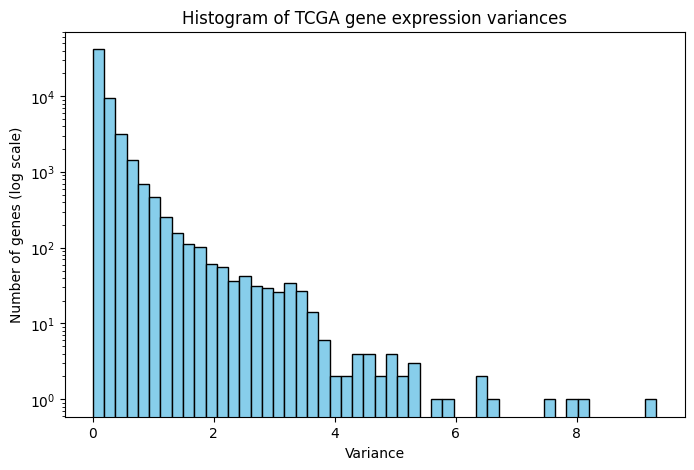

In [6]:
def plot_histo_gram_var(data):
    log_expr= np.log1p(data['data'])
    genes_var = np.var(log_expr, axis=0)
    plt.figure(figsize=(8,5))
    plt.hist(genes_var, bins=50, color='skyblue', edgecolor='black')
    plt.yscale('log')
    plt.title("Histogram of TCGA gene expression variances")
    plt.xlabel("Variance")
    plt.ylabel("Number of genes (log scale)")
    plt.show()
plot_histo_gram_var(tcga_data)

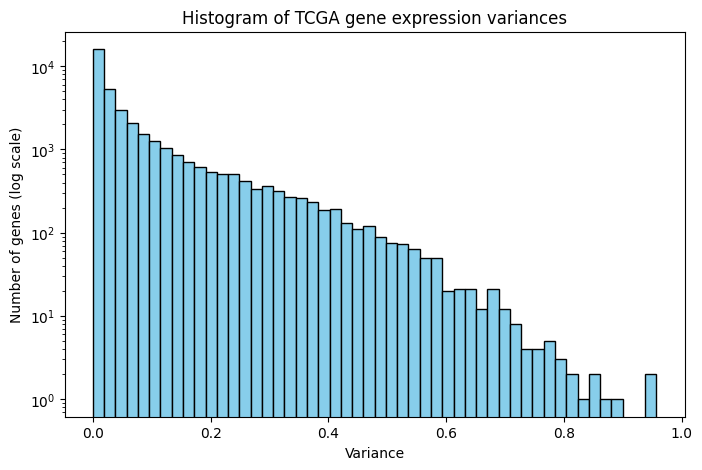

In [7]:
plot_histo_gram_var(gdsc_data)

In [8]:
def select_top_k_unique_fraction(data, k=1000):
    n_genes = len(data['gene_ids'])
    log_expr = np.log1p(data['data'])

    # Step 1: compute percentage of unique values per gene
    unique_fraction = np.array([
        len(np.unique(log_expr[:, i])) / log_expr.shape[0]
        for i in range(n_genes)
    ])

    top_gene_indices = np.argsort(unique_fraction)[-k:]  # indices of top genes

    return top_gene_indices

In [9]:
# lets check the number of common genes in TCGA and GDSC
tcga_mapping = tcga_data['id_to_symbol']
gdsc_mapping = gdsc_data['id_to_symbol']

In [10]:
# Remove version from tcga gene ids
tcga_gene_ids = [gene_id.split('.')[0] for gene_id in tcga_data['gene_ids']]
gdsc_gene_ids = gdsc_data['gene_ids']

print(f'# TCGA‌ Gene IDs: {len(tcga_gene_ids)}')
print(f'# GDSC‌ Gene IDs: {len(gdsc_gene_ids)}')
print(f'# Common‌ Gene IDs: {len(set(tcga_gene_ids).intersection(set(gdsc_gene_ids)))}')

# TCGA‌ Gene IDs: 58048
# GDSC‌ Gene IDs: 37373
# Common‌ Gene IDs: 36697


In [11]:
tcga_top_genes_indices = select_top_k_unique_fraction(tcga_data, k=1000)
gdsc_top_genes_indices = select_top_k_unique_fraction(gdsc_data, k=1000)

In [12]:
tcga_top_gene_ids = np.array(tcga_gene_ids)[tcga_top_genes_indices].tolist()
gdsc_top_gene_ids = np.array(gdsc_gene_ids)[gdsc_top_genes_indices].tolist()

In [13]:
# removing tcga selected genes that are not in GDSC genes
tcga_selected_genes_filtered = [tcga_gene_id for tcga_gene_id in tcga_top_gene_ids if tcga_gene_id in gdsc_gene_ids]
# removing gdsc selected genes that are not in TCGA‌ genes
gdsc_selected_genes_filtered = [gdsc_gene_id for gdsc_gene_id in gdsc_top_gene_ids if gdsc_gene_id in tcga_gene_ids]

In [14]:
print(f'Selected Filtered Genes GDSC: {len(gdsc_selected_genes_filtered)}')
print(f'Selected Filtered Genes TCGA: {len(tcga_selected_genes_filtered)}')
print(f'The Intersection between Two Gene Sets: {len(set(gdsc_selected_genes_filtered).intersection(set(tcga_selected_genes_filtered)))}')

Selected Filtered Genes GDSC: 997
Selected Filtered Genes TCGA: 995
The Intersection between Two Gene Sets: 233


In [15]:
all_selected_genes = sorted(list(set(gdsc_selected_genes_filtered + tcga_selected_genes_filtered)))

In [16]:
print('All selected genes:', len(all_selected_genes))

All selected genes: 1759


In [23]:
id_to_symbol = {}
for gene_id in all_selected_genes:
    id_to_symbol[gene_id] = tcga_data['id_to_symbol'][gene_id]

In [25]:
# reconstructing the gene expression profiles to make consistency in two datasets.
tcga_num_patients = tcga_data['data'].shape[0]
data = np.zeros((tcga_data['data'].shape[0], len(all_selected_genes)), dtype=np.float32)

for idx, gene_id in tqdm(enumerate(all_selected_genes), total=len(all_selected_genes)):
    ref_idx = tcga_gene_ids.index(gene_id)
    data[:,idx] = tcga_data['data'][:,ref_idx]


save_object = {
    'data':data,
    'gene_ids': all_selected_genes,
    'id_to_symbol': id_to_symbol,
    'patient_ids': tcga_data['patient_ids']
}

with open('storage/gene_expressions_cleaned/tcga.pkl','wb') as f:
    pickle.dump(save_object, f)

100%|██████████| 1759/1759 [00:00<00:00, 12263.33it/s]


In [27]:
# reconstructing the gene expression profiles to make consistency in two datasets.
gdsc_num_models = gdsc_data['data'].shape[0]
data = np.zeros((gdsc_num_models, len(all_selected_genes)), dtype=np.float32)

for idx, gene_id in tqdm(enumerate(all_selected_genes), total=len(all_selected_genes)):
    ref_idx = gdsc_gene_ids.index(gene_id)
    data[:,idx] = gdsc_data['data'][:,ref_idx]


save_object = {
    'data':data,
    'gene_ids': all_selected_genes,
    'id_to_symbol': id_to_symbol,
    'patient_ids': gdsc_data['model_names']
}

with open('storage/gene_expressions_cleaned/gdsc.pkl','wb') as f:
    pickle.dump(save_object, f)

100%|██████████| 1759/1759 [00:00<00:00, 10793.05it/s]


In [30]:
# healthy check tcga data
with open('storage/gene_expressions_cleaned/tcga.pkl','rb') as f:
    tcga_data = pickle.load(f)

print(tcga_data['data'].shape)
print(len(tcga_data['id_to_symbol']))
print(len(tcga_data['patient_ids']))
print(len(tcga_data['gene_ids']))

(1231, 1759)
1759
1231
1759


In [31]:
# healthy check gdsc data
with open('storage/gene_expressions_cleaned/gdsc.pkl','rb') as f:
    gdsc_data = pickle.load(f)

print(gdsc_data['data'].shape)
print(len(gdsc_data['id_to_symbol']))
print(len(gdsc_data['patient_ids']))
print(len(gdsc_data['gene_ids']))

(1783, 1759)
1759
1783
1759
